In [1]:
import pandas as pd 
import random
import matplotlib.pyplot as plt
import math
import numpy as np
import copy

# Homogenous case : 
p and alpha are the same for each players

In [2]:
class Individual:
    def __init__(self, initialWealth, riskCurve, alpha,index,behaviour):
        self.initialWealth = initialWealth #wealth
        self.wealth = initialWealth
        self.riskCurve = riskCurve 
        self.alpha = alpha #fraction lost during bad event
        self.behaviour = behaviour #Initialized randomly when a simulation is launched
        self.contribution = []
        self.finalWealthHistory = []#Wealth at the end of each game 
        self.index = index
        self.fitness = None
        
    def __repr__(self):
        #To output a string representaion of the object
        return ('Individual {}, behaviour : {}, wealth : {}'.format(self.index,str(self.behaviour),self.wealth))

 
    def generateRandomBehaviour(self,numberOfRounds):
        #instanciate a random behaviour
        self.behaviour = [[round(random.random(),2),round(random.random(),2),round(random.random(),2)] for i in range(numberOfRounds)]
        #self.behaviour = [[round(random.random(),2),i/numberOfRounds,i/numberOfRounds] for i in range(numberOfRounds)]
    def setBehaviour(self,behaviour):
        self.behaviour = behaviour
        
    def setFitnessValue(self):
        #to calculate the fitness value a the end of a generation (usefull to render new population)
        self.fitness =  np.exp(np.mean(self.finalWealthHistory))
        
    def Contribution(self, Cr,nround):
        beh= self.behaviour[nround]
        if(Cr<=beh[0]):
            return beh[1]
        else:
            return beh[2]
        
    
    def Step(self, Cr ,nround):
        #amount contributed to public good
        c = self.Contribution(Cr,nround)
        contribution = c*self.wealth
        #calculate what's left of wealth
        return contribution
    
    def addFinalWealthToHistory(self):
        #to add the ramaining wealth at the end of a game, the the mean is done to calculate the fitness at the end of a generation
        self.finalWealthHistory.append(self.wealth)
        
    def setWealth(self,newWealth):
        self.wealth = newWealth
        
    def resetRound(self):
        self.wealth = self.initialWealth
        
def addNoiseToTreshold(behav,sigma):
    #add noise to the treshold in the wrightFisher process
    for elem in behav:
        elem[0] += round(np.random.normal(0,sigma),2)
        elem[0] = max(0,elem[0])
        elem[0] = min(1,elem[0])



        
def risk(Cr,riskCurve,InitialWealth,lambda1,lambda2,lambda3):#chance of having bad event happening
    
    p1 = lambda Cr :1 -(lambda1*Cr/InitialWealth)
    p2 = lambda Cr: 1-10*Cr if Cr<0.1 else 0
    p3 = lambda Cr : 1-math.pow(Cr/InitialWealth,lambda2)
    p4 = lambda Cr: 1/(math.exp(lambda3*((Cr/InitialWealth)-0.5))+1)
    dic = {'linear':p1,'piecewiseLinear':p2,'powerlaw':p3,'treshold':p4}
    if (random.random() < dic[riskCurve](Cr)):
        return 1
    return 0


In [5]:
class Simulation:
    def __init__(self,numberOfRounds,alpha,riskCurve,wealth = 1,populationSize=100,numberOfGamesByGenerations=1000,numberOfGenerations=10000,mu=0.03,sigma=0.15,catastrophicEventSchedule = 'Every Rounds',displayContribution='Total'):
        #number of round : omega in the paper
        self.numberOfRounds = numberOfRounds
        self.numberOfGamesByGenerations = numberOfGamesByGenerations
        self.numberOfGenerations = numberOfGenerations
        self.wealth = wealth 
        self.alpha = alpha
        self.riskCurve = riskCurve
        self.populationSize = populationSize
        #create the first population
        self.population = self.createRandomPopulation()
        self.mu = mu
        self.sigma = sigma
        #schedule of the catastrophic event (last round, first round, every round or final round)
        self.catastrophicEventSchedule = catastrophicEventSchedule
        #set the schedule ie the round in wich player will loose wealth
        self.schedule = self.setEventSchedule()
         #display of the contribution : total if we want the mean of cooperation for every round, Every round if we want the detail for each round
        self.displayContribution = displayContribution 
        self.lambda1 = 1
        self.lambda2 = 10
        self.lambda3 = 10
        
    def createRandomPopulation(self):
        #create the first population
        population = np.array([Individual(self.wealth,self.riskCurve,self.alpha,i,None) for i in range(self.populationSize)])
        for individual in population:
            #initialize the behaviour (lenght = numberofRounds)
            individual.generateRandomBehaviour(self.numberOfRounds)
        #set a null behaviour to help convergence
        population[0].setBehaviour([[round(random.random(),2),0,0] for i in range(self.numberOfRounds)])
        return population
    
    def setEventSchedule(self):
        #create the event schedule
        if self.catastrophicEventSchedule == 'Every Rounds':
            schedule = np.ones(self.numberOfRounds, dtype=bool)
        elif self.catastrophicEventSchedule == 'First Round':
            schedule = np.zeros(self.numberOfRounds, dtype=bool)
            schedule[0] = True
            
        elif self.catastrophicEventSchedule == 'Last Round':
            schedule = np.zeros(self.numberOfRounds, dtype=bool)
            schedule[-1] = True
            
        elif self.catastrophicEventSchedule == 'Random Round':
            schedule = np.zeros(self.numberOfRounds, dtype=bool)
            r = np.random.randint(self.numberOfRounds)
            schedule[r] = True
        else:
            raise ValueError('Incorrect shedule argument passed')
        return schedule
            
    
    def renewPopulation(self):
        """
        renew population in function of the fitness of each individual, individual with high fitness are more likely to pass
        to the next generation
        """
        fitness = np.array([individual.fitness for individual in self.population])
        fitprop = fitness/np.sum(fitness)
        numoffspring = np.random.multinomial(self.populationSize, fitprop)
        a = []
        for j in range(len(numoffspring)):
            for i in range(numoffspring[j]):
                b = [elem for elem in self.population[j].behaviour]
                a.append(copy.deepcopy(b))
        return a
    

            
     
        
        
    
    def playGame(self,players):
        #play a game between two players (or more)
        Cr = 0 # initial public good 
        totalInitialWealth = np.sum([player.wealth for player in players])
        contributions=np.empty((len(players),self.numberOfRounds))
        for nround in range(self.numberOfRounds):
            #print('-----round ',nround)
            for i in range(len(players)):
                contributions[i,nround] = players[i].Step(Cr,nround)
            Cr += np.sum(contributions[:,nround])/totalInitialWealth
  
            if self.schedule[nround]:
                factor = (1-self.alpha*risk(Cr,self.riskCurve,players[i].initialWealth,self.lambda1,self.lambda2,self.lambda3))
            else:
                factor = 1
            for i in range(len(players)):
                newWealth = factor*(players[i].wealth-contributions[i,nround])
                players[i].setWealth(newWealth)
            
                
        for i in range(len(players)):
            players[i].contribution.append(contributions[i]/players[i].initialWealth)
                  
        for player in players:
            player.addFinalWealthToHistory()
            player.resetRound()
            
        
    
    def playGeneration(self):
        #for a certain number of iteration 2 players are selected randomly and the play a game
        for i in range(self.numberOfGamesByGenerations):
            players = np.random.choice(self.population,2,replace=False)
            self.playGame(players)

    def wrightFisher(self): 
        #renew the population and add noise
        #print('1---------',self.population)
        newBehaviours = self.renewPopulation()
        for behav in newBehaviours:
            a = np.random.rand()
            b = np.random.rand()
            if a<self.mu:
                for elem in behav:
                    elem[0] += round(np.random.normal(0,self.sigma),2)
                    elem[0] = max(0,elem[0])
                    elem[0] = min(1,elem[0])
            if b<self.mu:
                for elem in behav:
                    elem[1] = round(np.random.uniform(0,1),2)
                    elem[2] = round(np.random.uniform(0,1),2)
        self.population = [Individual(self.wealth,self.riskCurve,self.alpha,i,newBehaviours[i]) for i in range(self.populationSize)]
        #print('2---------',self.population)
        
            
    def setLamda(self, lmbda):
        self.lambda1 = lmbda
        self.lambda2 = lmbda
        self.lambda3 = lmbda
        
    def runSim(self):
        #lauch a simulation 
        averageResults = []

        for i in range(self.numberOfGenerations):
            self.playGeneration()
            contributionValues = []
            for j in range(self.populationSize):
                self.population[j].setFitnessValue()
                if (self.displayContribution =='Total'):
                    TotalContribution = [np.sum(elem) for elem in self.population[j].contribution]
                    mean = np.mean(TotalContribution)
                    contributionValues.append(mean)
                elif (self.displayContribution =='Every Round'):
                    mean = np.mean(self.population[j].contribution,axis = 0)
                    contributionValues.append(mean)
                else:
                    raise ValueError('incorrect dispalyContribution argument passed') 
                    
            if (self.numberOfGenerations-50<=i<self.numberOfGenerations):
                averageResults.append(np.mean(contributionValues,axis = 0))
            self.wrightFisher() 
        av = np.mean(averageResults,axis=0)
        #print('for omega = {},alpha = {}, riskurve : {}, c = {}'.format(self.numberOfRounds,self.alpha,self.riskCurve,av))
        return av

    

            
        
            
        
    

In [283]:
sim = Simulation(2,1,'treshold',numberOfGenerations = 10,mu = 0.03,displayContribution = 'Every Round')
sim.runSim()

array([ 0.48093   ,  0.09625085])

In [ ]:
alpha = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
riskCurve = ['piecewiseLinear','linear','treshold','powerlaw']
omega = [1,2,4]

In [100]:
results = np.zeros((len(omega),len(riskCurve),len(alpha)))
for o in omega:
    for r in riskCurve:
        for a in alpha:
            sim = Simulation(o,a,r,numberOfGenerations = 100)
            results[o,r,a] = sim.runSim() 
            
            

----------Generation 0
contribution : 0.5357
0.10314
----------Generation 0
contribution : 0.4597
0.230226
----------Generation 0
contribution : 0.4539
0.461492
----------Generation 0
contribution : 0.5138
0.61319


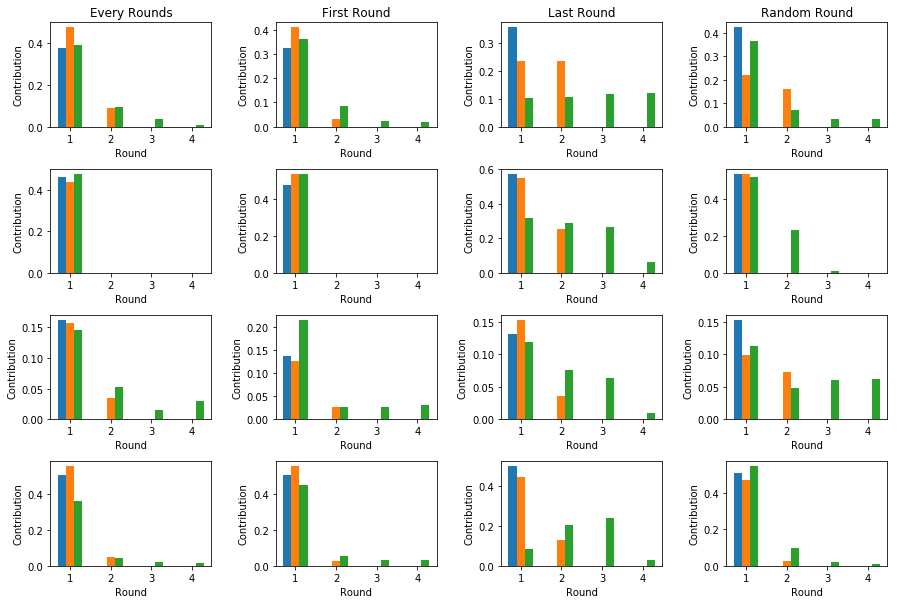

In [215]:

#plot Contributions for different timings of potential losses in a game with up to four rounds and four different risk curves
fig = plt.figure(figsize=(15,10))

fig.subplots_adjust(hspace=0.4, wspace=0.4)
omega = [1,2,4]
riskCurve = ['linear','powerlaw','piecewiseLinear','treshold']
catastrophicEvent = ['Every Rounds','First Round','Last Round','Random Round']
i = 1
for r in riskCurve:
    for c in catastrophicEvent:
        res =[]
        for o in omega:
            sim = Simulation(o,1,r,populationSize=100,catastrophicEventSchedule = c,numberOfGenerations = 1000,displayContribution='Every Round')
            temp = sim.runSim()
            res.append(temp)
        delta = -0.2
        ax = fig.add_subplot(4, 4, i)
        if (i<5):
            plt.title(c)
        plt.xlabel('Round')
        plt.ylabel('Contribution')
        plt.ylim(0,0.6)
        for y in res:
            N = len(y)
            x = np.arange(1,N+1)
            ax.bar(x+delta,y,width=0.2)
            delta+=0.2

        i+=1
                
plt.show()

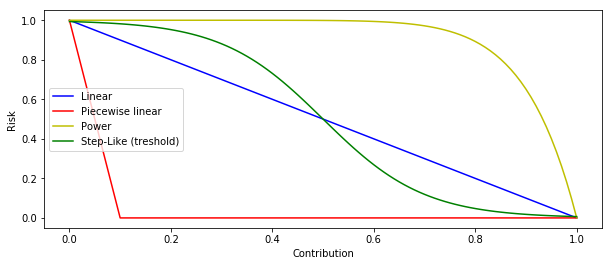

In [57]:
#Risk curves plotting
lambda1 = 1
InitialWealth = 1
lambda2 = 10
lambda3 = 10

p1 = lambda Cr :1 -(lambda1*Cr/InitialWealth)
p2 = lambda Cr: 1-10*Cr if Cr<0.1 else 0
p3 = lambda Cr : 1-math.pow(Cr/InitialWealth,lambda2)
p4 = lambda Cr: 1/(math.exp(lambda3*((Cr/InitialWealth)-0.5))+1)

xas = np.arange(0.0, 1.01, 0.01)
yas = [ p1(x) for x in xas ]
yas2 = [p2(x) for x in xas] 
yas3 = [p3(x) for x in xas] 
yas4 = [p4(x) for x in xas] 
plt.figure(figsize=(10,4))
plt.plot(xas, yas,'b',label = 'Linear ')
plt.plot(xas, yas2,'r',label='Piecewise linear')
plt.plot(xas, yas3,'y', label = 'Power')
plt.plot(xas, yas4,'g', label = 'Step-Like (treshold)')
plt.xlabel('Contribution')
plt.ylabel('Risk')
plt.legend()
plt.show()

omega: 1, Riskcurve: linear
omega: 1, Riskcurve: powerlaw
omega: 1, Riskcurve: treshold
omega: 4, Riskcurve: linear
omega: 4, Riskcurve: powerlaw
omega: 4, Riskcurve: treshold


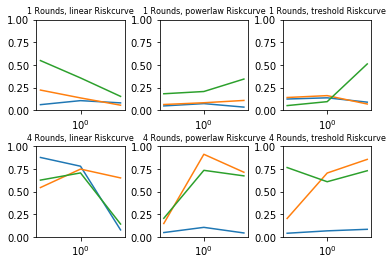

In [7]:
#plot 5:Exploring the shape of risk curves
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
i = 1
alpha = [0.1,0.5,0.9]
lmbda = [0.01,1,100]
riskCurve = ['linear','powerlaw','treshold']
omega = [1,4]
for o in omega:
    for r in riskCurve:
        print("omega: "+ str(o)+", Riskcurve: "+r)
        ax = fig.add_subplot(2, 3, i)
        ax.set_xscale('log')
        i+=1
        for a in alpha:
            res = []
            for l in lmbda:
                sim = Simulation(o,a,r,populationSize=20,numberOfGenerations = 100);
                sim.setLamda(l)
                res.append(np.sum(sim.runSim()))
            ax.plot(lmbda,res)
            ax.set_title(str(o)+" Rounds, "+str(r) +" Riskcurve", fontsize=8)
            ax.set_ylim([0,1])

# Non Homogeneous Case


In [295]:
class SimulationNonHomogeneous:
    def __init__(self,numberOfRounds,alphaRich,alphaPoor,riskCurve,wealthPoor = 1,wealthRich = 4,populationSize=100,numberOfGamesByGenerations=1000,numberOfGenerations=10000,mu=0.03,sigma=0.15,catastrophicEventSchedule = 'Every Rounds',displayContribution='Total',fractionOfPoor = 0.5,mixedGame = False):
        self.numberOfRounds = numberOfRounds
        self.fractionOfPoor = fractionOfPoor
        self.numberOfGamesByGenerations = numberOfGamesByGenerations
        self.numberOfGenerations = numberOfGenerations
        self.wealthPoor = wealthPoor
        self.wealthRich = wealthRich
        self.alphaRich = alphaRich
        self.alphaPoor = alphaPoor
        self.riskCurve = riskCurve
        self.populationSize = populationSize
        #create the first population
        self.populationPoor, self.populationRich = self.createRandomPopulation()
        self.mu = mu
        self.sigma = sigma
        self.catastrophicEventSchedule = catastrophicEventSchedule
        self.schedule = self.setEventSchedule()
        self.displayContribution = displayContribution 
        self.mixedGame = mixedGame
        self.lambda1 = 1
        self.lambda2 = 10
        self.lambda3 = 10
        
    def createRandomPopulation(self):
        #create the first population
        populationPoor = []
        populationRich = []
        for i in range(self.populationSize):
            if np.random.rand()<self.fractionOfPoor:
                ind = Individual(self.wealthPoor,self.riskCurve,self.alphaPoor,i,None)
                ind.generateRandomBehaviour(self.numberOfRounds)
                populationPoor.append(ind)
            else:
                ind = Individual(self.wealthRich,self.riskCurve,self.alphaRich,i,None)
                ind.generateRandomBehaviour(self.numberOfRounds)
                populationRich.append(ind)
                
        populationPoor[0].setBehaviour([[round(random.random(),2),0,0] for i in range(self.numberOfRounds)])
        populationRich[0].setBehaviour([[round(random.random(),2),0,0] for i in range(self.numberOfRounds)])
        return populationPoor,populationRich
    
    def setEventSchedule(self):
        if self.catastrophicEventSchedule == 'Every Rounds':
            schedule = np.ones(self.numberOfRounds, dtype=bool)
            
        elif self.catastrophicEventSchedule == 'First Round':
            schedule = np.zeros(self.numberOfRounds, dtype=bool)
            schedule[0] = True
            
        elif self.catastrophicEventSchedule == 'Last Round':
            schedule = np.zeros(self.numberOfRounds, dtype=bool)
            schedule[-1] = True
            
        elif self.catastrophicEventSchedule == 'Random Round':
            schedule = np.zeros(self.numberOfRounds, dtype=bool)
            r = np.random.randint(self.numberOfRounds)
            schedule[r] = True
        else:
            raise ValueError('Incorrect shedule argument passed')
        return schedule
            
    
    def renewPopulationRich(self):
        fitness = np.array([individual.fitness for individual in self.populationRich])
        fitprop = fitness/np.sum(fitness)
        numoffspring = np.random.multinomial(len(self.populationRich), fitprop)
        a = []
        for j in range(len(numoffspring)):
            for i in range(numoffspring[j]):
                b = [elem for elem in self.populationRich[j].behaviour]
                #memory[counter+i] = b
                a.append(copy.deepcopy(b))
        return a
    
    def renewPopulationPoor(self):
        fitness = np.array([individual.fitness for individual in self.populationPoor])
        fitprop = fitness/np.sum(fitness)
        numoffspring = np.random.multinomial(len(self.populationPoor), fitprop)
        a = []
        for j in range(len(numoffspring)):
            for i in range(numoffspring[j]):
                b = [elem for elem in self.populationPoor[j].behaviour]
                #memory[counter+i] = b
                a.append(copy.deepcopy(b))
        return a
    

                
    def playGame(self,players):
        #play a game between two players (or more)
        Cr = 0 # initial public good 
        totalInitialWealth = np.sum([player.wealth for player in players])
        contributions=np.empty((len(players),self.numberOfRounds))
        for nround in range(self.numberOfRounds):
            #print('-----round ',nround)
            for i in range(len(players)):
                contributions[i,nround] = players[i].Step(Cr,nround)
            Cr += np.sum(contributions[:,nround])/totalInitialWealth
            for i in range(len(players)):
                newWealth = (1-self.schedule[nround]*players[i].alpha*risk(Cr,self.riskCurve,self.wealthRich+self.wealthPoor,self.lambda1,self.lambda2,self.lambda3))*(players[i].wealth-contributions[i,nround])
                players[i].setWealth(newWealth)
 
        for i in range(len(players)):
            players[i].contribution.append(contributions[i]/players[i].initialWealth)

                  
        for player in players:
            player.addFinalWealthToHistory()
            player.resetRound()
            
        
    
    def playGeneration(self):
        #for a certain number of iteration 2 players are selected randomly and the play a game
        for i in range(self.numberOfGamesByGenerations):
            if self.mixedGame == False:
                players = [np.random.choice(self.populationPoor,replace=False),np.random.choice(self.populationRich,replace=False)]
            elif self.mixedGame == True:
                population = self.populationPoor + self.populationRich
                players = np.random.choice(population,2,replace=False)
            else:
                raise ValueError('incorrect mixedGame argument passed') 
            self.playGame(players)
        

        

    def wrightFisher(self): 
        #print('1---------',self.population)
        newBehavioursRich = self.renewPopulationRich()
        newBehavioursPoor = self.renewPopulationPoor()
        for behav in newBehavioursRich:
            a = np.random.rand()
            b = np.random.rand()
            if a<self.mu:
                for elem in behav:
                    elem[0] += round(np.random.normal(0,self.sigma),2)
                    elem[0] = max(0,elem[0])
                    elem[0] = min(1,elem[0])
            if b<self.mu:
                for elem in behav:
                    elem[1] = round(np.random.uniform(0,1),2)
                    elem[2] = round(np.random.uniform(0,1),2)
                    
        for behav in newBehavioursPoor:
            a = np.random.rand()
            b = np.random.rand()
            if a<self.mu:
                for elem in behav:
                    elem[0] += round(np.random.normal(0,self.sigma),2)
                    elem[0] = max(0,elem[0])
                    elem[0] = min(1,elem[0])
            if b<self.mu:
                for elem in behav:
                    elem[1] = round(np.random.uniform(0,1),2)
                    elem[2] = round(np.random.uniform(0,1),2)
                    
        self.populationRich = [Individual(self.wealthRich,self.riskCurve,self.alphaRich,i,newBehavioursRich[i]) for i in range(len(self.populationRich))]
        self.populationPoor = [Individual(self.wealthPoor,self.riskCurve,self.alphaPoor,i,newBehavioursPoor[i]) for i in range(len(self.populationPoor))]
        #print('2---------',self.population)
        
    
    def runSim(self):
        averageResultsRich = []
        averageResultsPoor = []
        #lauch a simulation 
        for i in range(self.numberOfGenerations):
            self.playGeneration()
            contributionValuesPoor = []
            contributionValuesRich = []
            
            for j in range(len(self.populationRich)):
                self.populationRich[j].setFitnessValue()
                if (self.displayContribution =='Total'):
                    TotalContributionRich = [np.sum(elem) for elem in self.populationRich[j].contribution]
                    mean = np.mean(TotalContributionRich)
                    contributionValuesRich.append(mean)
                elif (self.displayContribution =='Every Round'):
                    mean = np.mean(self.populationRich[j].contribution,axis = 0)
                    contributionValuesRich.append(mean)
                else:
                    raise ValueError('incorrect dispalyContribution argument passed') 
                    
            for j in range(len(self.populationPoor)):
                self.populationPoor[j].setFitnessValue()
                if (self.displayContribution =='Total'):
                    TotalContributionPoor = [np.sum(elem) for elem in self.populationPoor[j].contribution]
                    mean = np.mean(TotalContributionPoor)
                    contributionValuesPoor.append(mean)
                elif (self.displayContribution =='Every Round'):
                    mean = np.mean(self.populationPoor[j].contribution,axis = 0)
                    contributionValuesPoor.append(mean)
                else:
                    raise ValueError('incorrect dispalyContribution argument passed')
                    
            if (self.numberOfGenerations-100<=i<self.numberOfGenerations):
                averageResultsRich.append(np.mean(contributionValuesRich,axis = 0))
                averageResultsPoor.append(np.mean(contributionValuesPoor,axis = 0))
                
            self.wrightFisher() 
        avRich = np.mean(averageResultsRich,axis=0)
        avPoor = np.mean(averageResultsPoor,axis=0)
        print('for omega = {},alpha rich = {}, alpha poor = {}, riskurve : {}, timing : {} cRich = {}, cPoor = {}'.format(self.numberOfRounds,self.alphaRich,self.alphaPoor,self.riskCurve,self.catastrophicEventSchedule,avRich,avPoor))
        return avRich,avPoor

    

            

In [204]:
simNH =SimulationNonHomogeneous(2,0,1,'treshold',numberOfGenerations = 10,fractionOfPoor = 0.5,catastrophicEventSchedule = 'Random Round')
simNH.runSim()

In [223]:
a = [1,2]
np.random.choice(a,replace = False)


array([2])

In [280]:
fig = plt.figure(figsize=(16,6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

alphaRich = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
catastrophicEvent = ['Every Rounds','First Round','Last Round','Random Round']
alphaPoor = [1,0.5]
i = 1
for ap in alphaPoor:
    for c in catastrophicEvent:
        res =[]
        for ar in alphaRich:
            simNH =SimulationNonHomogeneous(4,ar,ap,'treshold',numberOfGenerations = 1000,fractionOfPoor = 0.5,catastrophicEventSchedule = c)
            res += simNH.runSim() 
        cRich = res[::2]  
        cPoor = res[1::2]
        ax = fig.add_subplot(2, 4, i)
        if (i<5):
            plt.title(c)
        ax.plot(alphaRich,cRich,'r')
        ax.plot(alphaRich,cPoor,'b')
        plt.ylim(0,1)
        plt.xlim(0,1.1)
        plt.xlabel(r'Loss fraction : $\alpha_R$')
        plt.ylabel('Contribution')
        ax.legend(('Rich','Poor'),loc ='lower left')
        i+=1
plt.show()        


for omega = 4,alpha rich = 0, alpha poor = 1, riskurve : treshold, timing : Every Rounds cRich = 0.032448498115801826, cPoor = 0.6841034382371938
for omega = 4,alpha rich = 0.1, alpha poor = 1, riskurve : treshold, timing : Every Rounds cRich = 0.02833789663513898, cPoor = 0.6013897166302774
for omega = 4,alpha rich = 0.2, alpha poor = 1, riskurve : treshold, timing : Every Rounds cRich = 0.03167050093390491, cPoor = 0.5891451613302519
for omega = 4,alpha rich = 0.3, alpha poor = 1, riskurve : treshold, timing : Every Rounds cRich = 0.2782334519016296, cPoor = 0.6010892545345962
for omega = 4,alpha rich = 0.4, alpha poor = 1, riskurve : treshold, timing : Every Rounds cRich = 0.04558847273560222, cPoor = 0.29454490399574196
for omega = 4,alpha rich = 0.5, alpha poor = 1, riskurve : treshold, timing : Every Rounds cRich = 0.08861079764988421, cPoor = 0.4254574092406535
for omega = 4,alpha rich = 0.6, alpha poor = 1, riskurve : treshold, timing : Every Rounds cRich = 0.5553791488663192, 

KeyboardInterrupt: 

for omega = 4,alpha rich = 1, alpha poor = 1, riskurve : treshold, timing : Every Rounds cRich = [  2.89960000e-01   3.32624146e-03   8.58034828e-05   0.00000000e+00], cPoor = [  6.52820000e-01   2.00979782e-03   2.58138462e-06   0.00000000e+00]
for omega = 4,alpha rich = 1, alpha poor = 1, riskurve : treshold, timing : First Round cRich = [ 0.46548837  0.00237138  0.00114759  0.00113129], cPoor = [ 0.45364912  0.0043627   0.0026983   0.00106112]
for omega = 4,alpha rich = 1, alpha poor = 1, riskurve : treshold, timing : Last Round cRich = [ 0.566625    0.20075689  0.05778865  0.08067121], cPoor = [ 0.44411538  0.27998789  0.11515766  0.10505185]
for omega = 4,alpha rich = 1, alpha poor = 1, riskurve : treshold, timing : Random Round cRich = [ 0.2314898   0.00648563  0.00092373  0.0005217 ], cPoor = [ 0.32607843  0.00249556  0.00235704  0.00378252]
for omega = 4,alpha rich = 0.8, alpha poor = 1, riskurve : treshold, timing : Every Rounds cRich = [  4.95333333e-01   5.58719403e-02   4.6

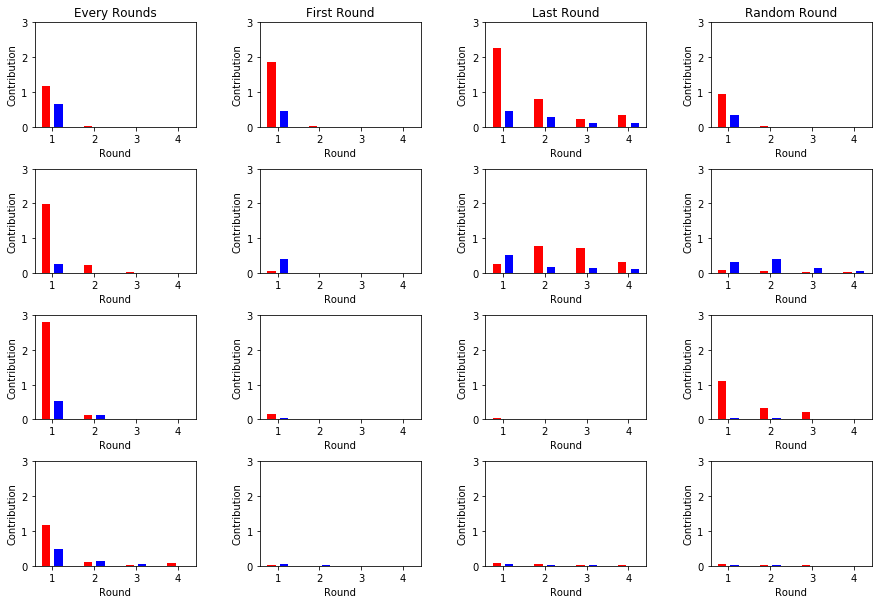

In [298]:
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

alphaPoor = [1,1,0.5,0.5]
alphaRich = [1,0.8,0.8,0.5]
catastrophicEvent = ['Every Rounds','First Round','Last Round','Random Round']
i = 1
for j in range(4):
    for c in catastrophicEvent:
        simNH =SimulationNonHomogeneous(4,alphaRich[j],alphaPoor[j],'treshold',numberOfGenerations = 1000,fractionOfPoor = 0.5,catastrophicEventSchedule = c,displayContribution='Every Round')
        res = simNH.runSim()
        cRich = np.multiply(res[::2],simNH.wealthRich)
        cPoor = np.multiply(res[1::2],simNH.wealthPoor)
        ax = fig.add_subplot(4, 4, i)
        delta = -0.15
        gamma = 0.15
        if (i<5):
            plt.title(c)
        plt.ylim(0,3)
        plt.xlabel('Round')
        plt.ylabel('Contribution')
        
        
        for y in cRich:
            x = np.arange(1,5)
            ax.bar(x+delta,y,width=0.2,color = 'r',label='Rich')
            #delta+=0.4
           
        for y in cPoor:
            x = np.arange(1,5)
            ax.bar(x+gamma,y,width=0.2,color = 'b',label='Poor')
            #gamma+=0.4
        
        
        i+=1
        
plt.show()        
        

for omega = 2,alpha rich = 1, alpha poor = 1, riskurve : treshold, timing : Every Rounds cRich = 0.2860030519477121, cPoor = 0.28289647675465934
for omega = 2,alpha rich = 1, alpha poor = 1, riskurve : treshold, timing : Every Rounds cRich = 0.40895515472628335, cPoor = 0.5340159163133552
for omega = 2,alpha rich = 1, alpha poor = 1, riskurve : treshold, timing : Every Rounds cRich = 0.5506616498801911, cPoor = 0.5485626444112527
for omega = 2,alpha rich = 1, alpha poor = 1, riskurve : treshold, timing : Every Rounds cRich = 0.794055640724393, cPoor = 0.5021065443150511
for omega = 2,alpha rich = 1, alpha poor = 1, riskurve : treshold, timing : Every Rounds cRich = 0.6385490735750656, cPoor = 0.6294387504404833


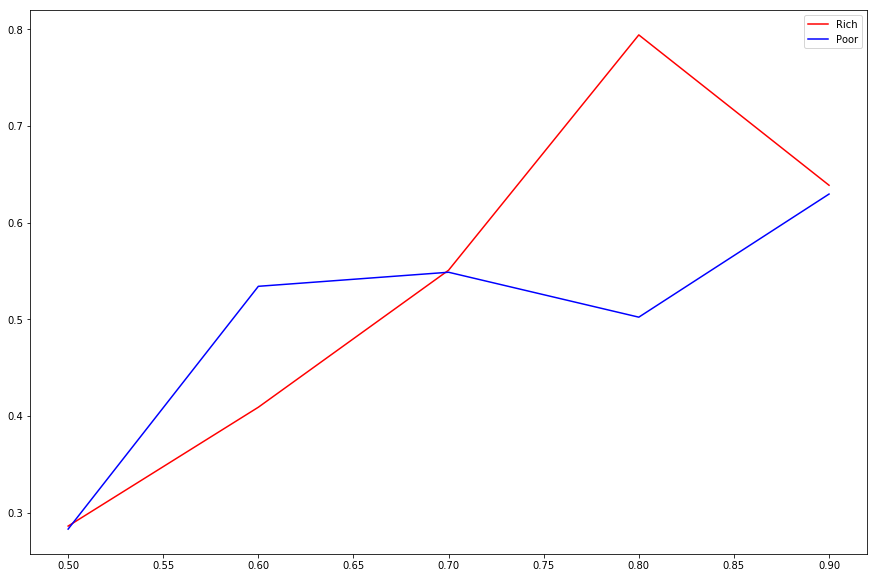

In [296]:
fig = plt.figure(figsize=(15,10))
fracpoor = [0.5,0.6,0.7,0.8,0.9]
res = []
for f in fracpoor:
        simNH =SimulationNonHomogeneous(2,1,1,'treshold',numberOfGenerations = 100,fractionOfPoor = f,catastrophicEventSchedule = c,mixedGame=True)
        res += simNH.runSim()
res[::2]
res[1::2]
plt.plot(fracpoor,res[::2],'r')
plt.plot(fracpoor,res[1::2],'b')
plt.legend(('Rich','Poor'),loc=0)
plt.show()
        